# COGS 189 Final Project

This project aims to </br>
Group Members: 
Stephen Gelinas (A15816513)
Aditya Tomar (A17162996)
Shay Samat
Rolando Restua
Kevin Wong 

## Data Loading

We will first load and inspect the raw EEG data we collected with OpenBCI

In [32]:
# required imoprts
import pandas as pd
from IPython.display import Image
import numpy as np
import mne
import matplotlib as plt
import matplotlib.pyplot as plt

In [33]:
# read EEG data
df = pd.read_csv('data/eeg.txt')
df.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Accel Channel 0,...,Other.3,Other.4,Other.5,Other.6,Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Other.7,Timestamp (Formatted)
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.386,...,12.0,48.0,229.0,48.0,0.0,0.0,0.0,1.678216e+09,0.0,2023-03-07 10:58:21.792
1,1.0,20007.337035,7455.603177,2753.377289,2629.906253,1095.973086,1520.455065,9324.119607,7072.449574,0.386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.678216e+09,0.0,2023-03-07 10:58:21.809
2,2.0,20010.935665,7457.324261,2753.645510,2630.867378,1089.558135,1516.051771,9328.612307,7063.553579,0.386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.678216e+09,0.0,2023-03-07 10:58:21.812
3,3.0,20021.329227,7457.458372,2753.176123,2630.599157,1083.947847,1517.772855,9331.875662,7054.121143,0.386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.678216e+09,0.0,2023-03-07 10:58:21.815
4,4.0,20028.168860,7457.123096,2753.042013,2630.152122,1082.249115,1522.489074,9335.429589,7034.541015,0.386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.678216e+09,0.0,2023-03-07 10:58:21.818


There appears to be no missing values from the data collection process in the raw EEG data

In [ ]:
# determine if any values are missing
df.isna().sum()

The image below illustrates locations of the 8 selected channels for the data collection process (including GND and REF) 

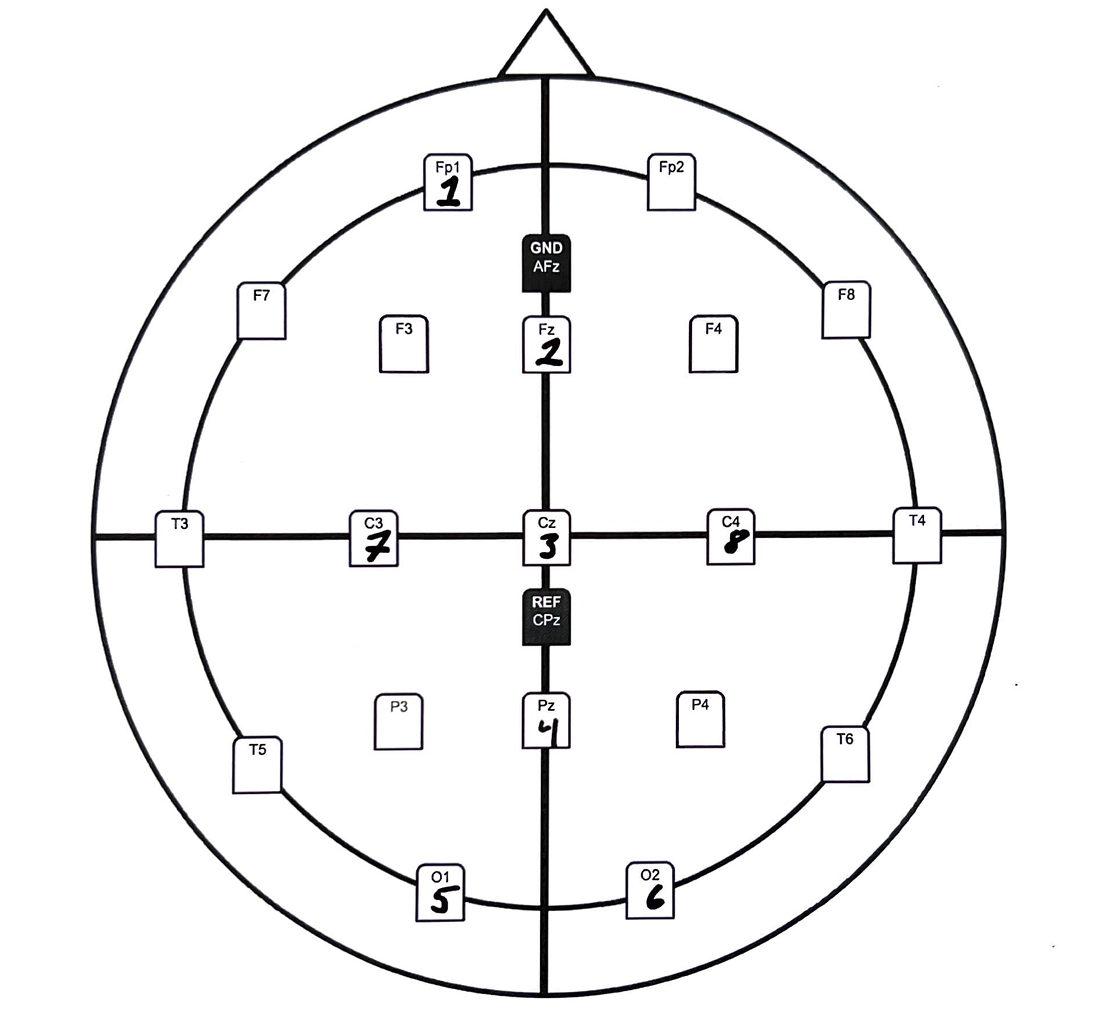

In [61]:
Image("data/channels.png", width=400)

## Data Cleaning/Preprocessing

In [ ]:
# "Other" channels that didn't collect EEG data
df[[' Other', ' Other.7']].value_counts().to_frame(name='Total Count')

In [ ]:
# "Analog" channels that didn't collect EEG data
analog = [' Analog Channel 0', ' Analog Channel 1', ' Analog Channel 2']
df[analog].value_counts().to_frame(name='Total Count')

In [ ]:
# drop data from these channels
dropped = [' Other', ' Other.7', ' Analog Channel 0', ' Analog Channel 1', ' Analog Channel 2']
df_cleaned = df.drop(columns=dropped)

In [34]:
# Get the sampling frequency from the timestamps
sfreq = 1 / np.mean(np.diff(df[' Timestamp']))

# Convert the data to MNE format
ch_names = df.columns[1:9].tolist()
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
data = df[ch_names].values.T.astype(np.float32)
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=8, n_times=248554
    Range : 0 ... 248553 =      0.000 ...   993.292 secs
Ready.


Using matplotlib as 2D backend.


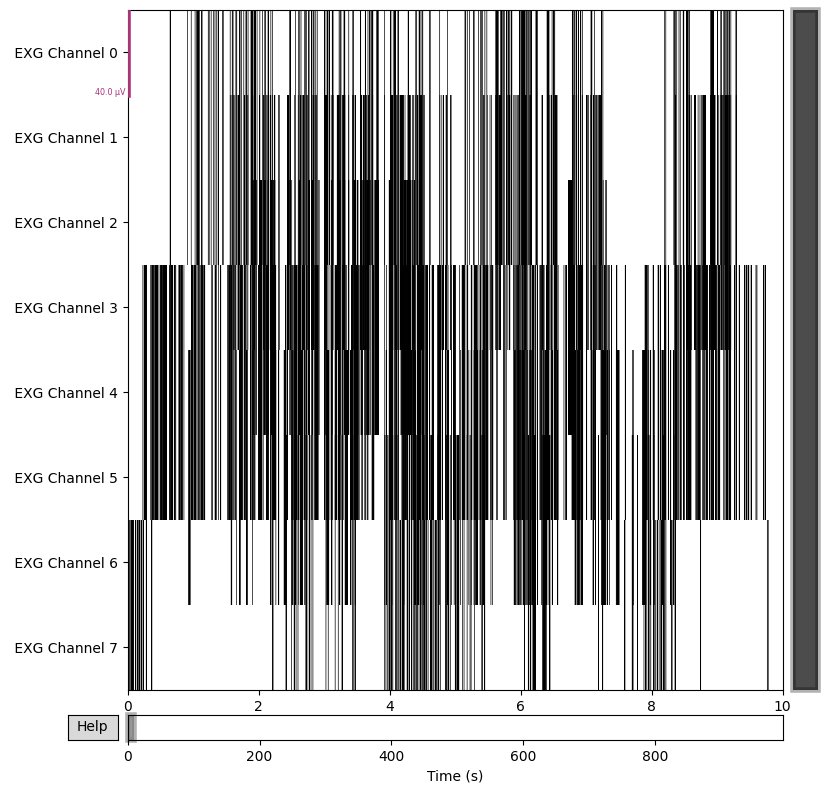

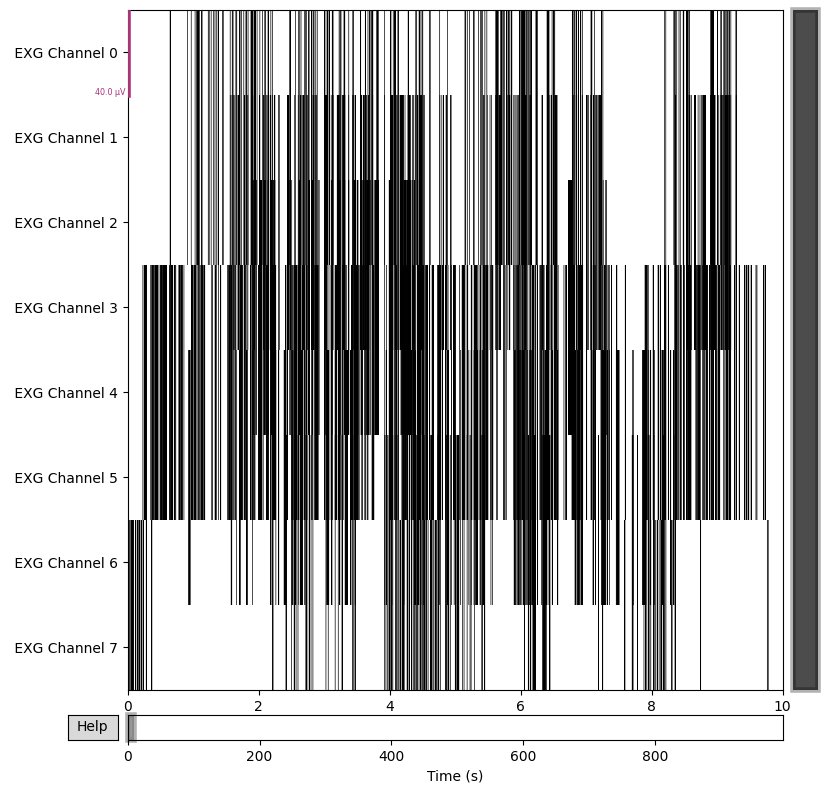

In [35]:
raw.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.184 (s)


/var/folders/tm/84lbt1dd25b7bgsx7m5x8wlm0000gn/T/ipykernel_48113/3991090996.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


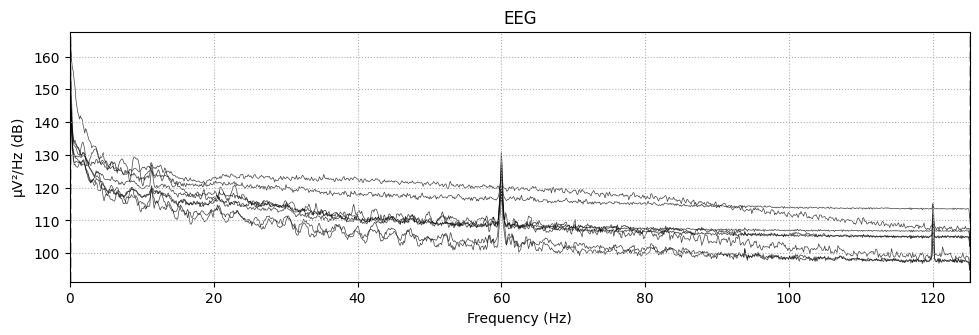

In [36]:
# Plot raw PSD
raw.plot_psd()

In [ ]:
# Get the accelerometer data
accelerometer_data = df[[' Accel Channel 0', ' Accel Channel 1', ' Accel Channel 2']].values.T.astype(np.float32)

# Calculate the norm of the accelerometer data to get the overall acceleration
acceleration = np.linalg.norm(accelerometer_data, axis=0)

# Identify and remove segments with high acceleration (i.e. head movements)
threshold = np.percentile(acceleration, 95)
bad_segments = np.where(acceleration > threshold)[0]
raw.annotations.append(bad_segments, [1] * len(bad_segments), 'bad')

# Interpolate bad segments
raw.interpolate_bads(reset_bads=True)

In [37]:
# Apply high-pass filter to remove eye movements and remove slow drifts
raw.filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 827 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


<RawArray | 8 x 248554 (993.3 s), ~15.2 MB, data loaded>

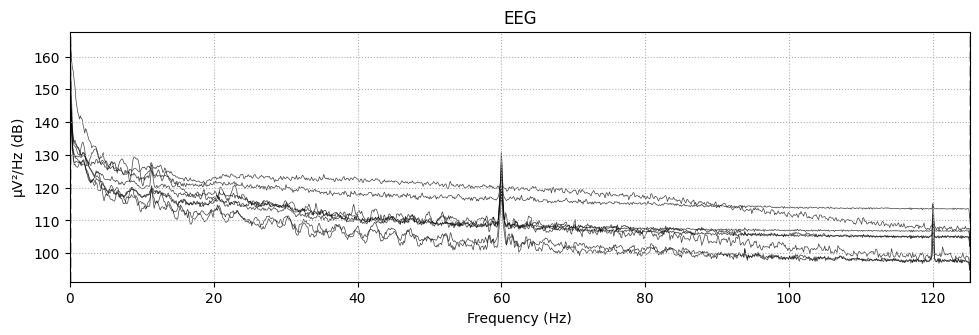

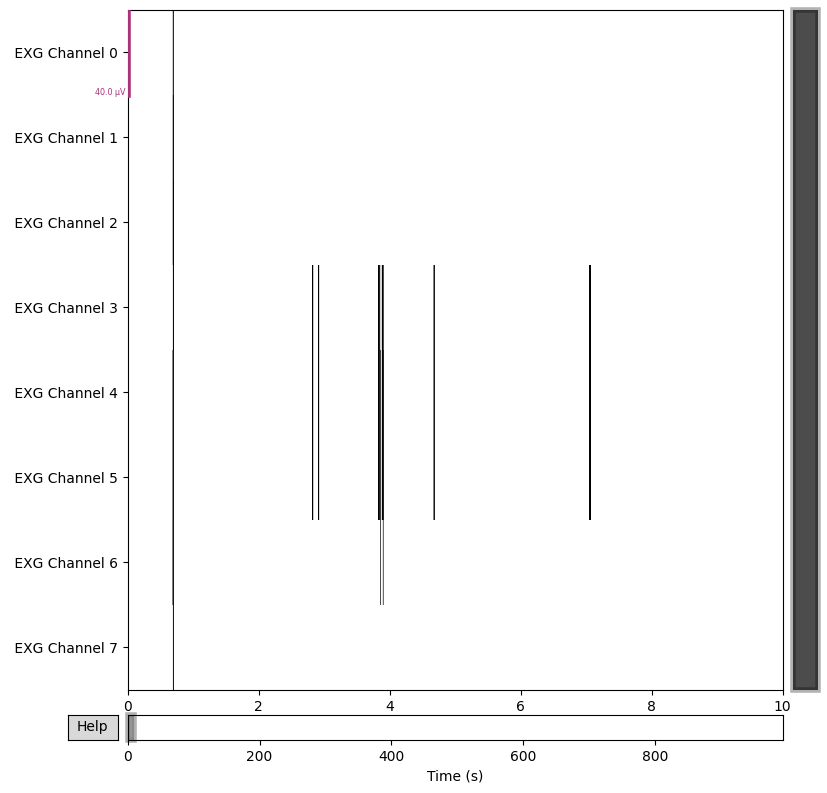

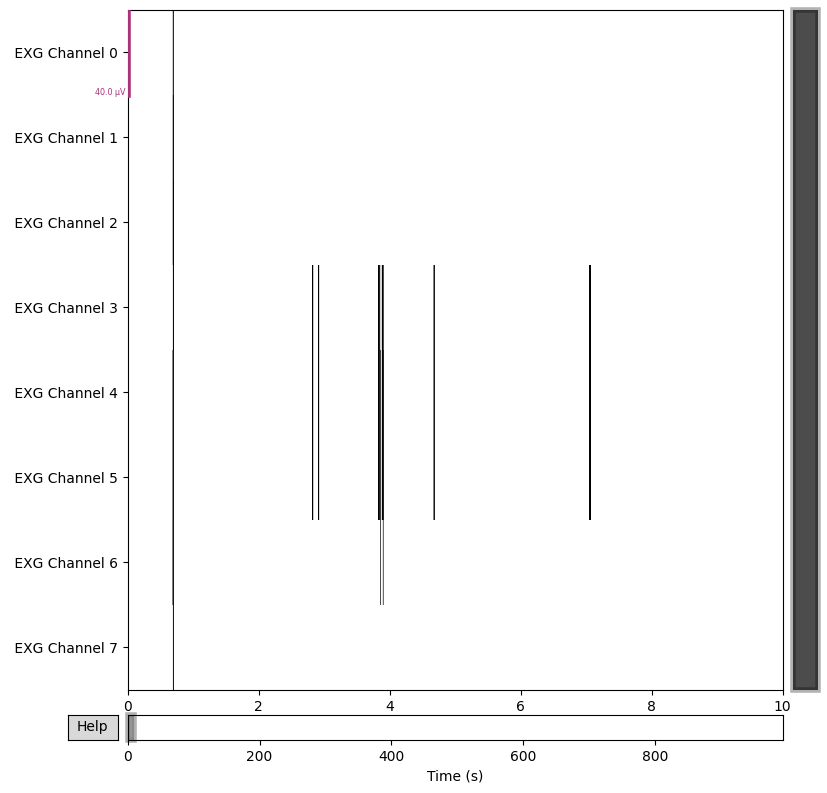

In [38]:
raw.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.184 (s)


/var/folders/tm/84lbt1dd25b7bgsx7m5x8wlm0000gn/T/ipykernel_48113/2847632005.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


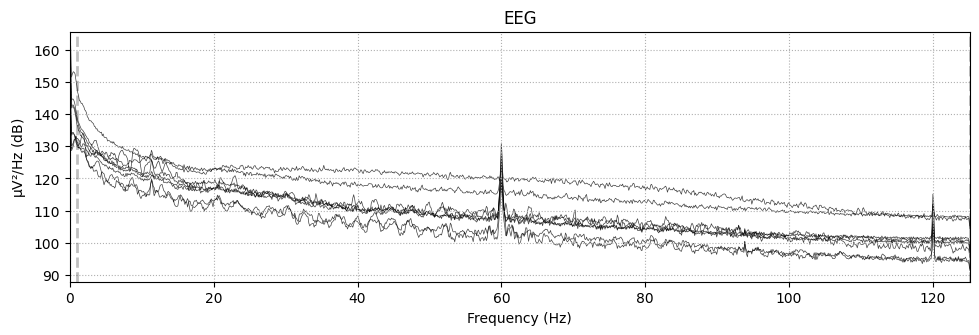

In [39]:
raw.plot_psd()

In [40]:
# Apply low-pass filter to remove eye blinks and high-frequency noise

raw.filter(l_freq=0, h_freq=40.0)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 83 samples (0.332 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s finished


<RawArray | 8 x 248554 (993.3 s), ~15.2 MB, data loaded>

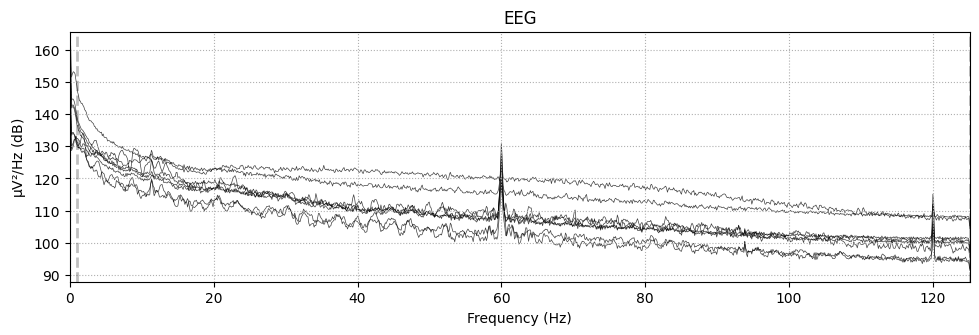

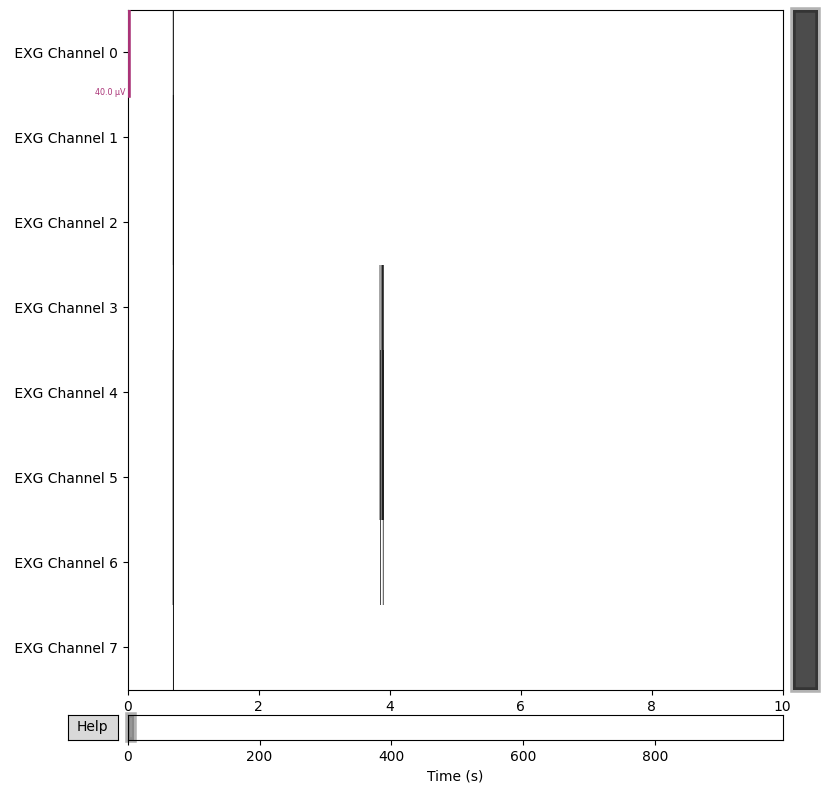

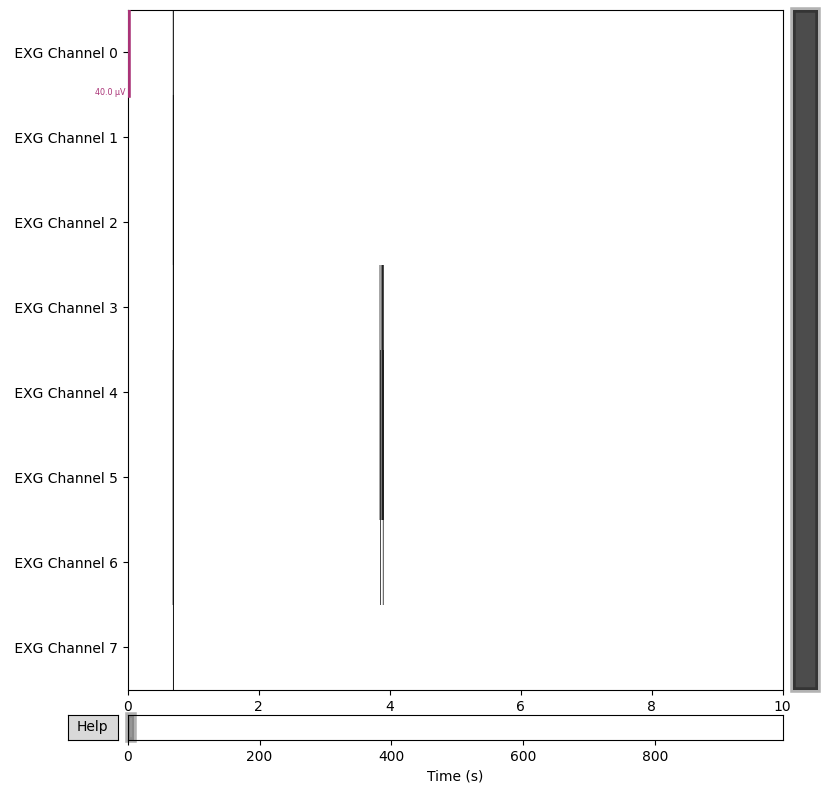

In [41]:
raw.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.184 (s)


/var/folders/tm/84lbt1dd25b7bgsx7m5x8wlm0000gn/T/ipykernel_48113/2847632005.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


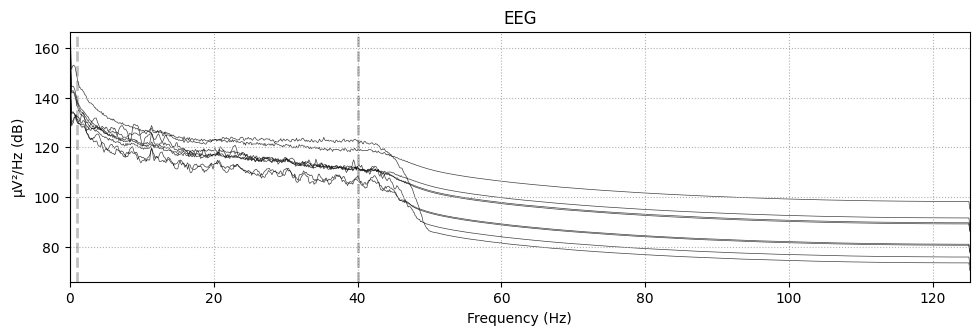

In [42]:
raw.plot_psd()

In [49]:
# Get the preprocessed data as a numpy array
df_cleaned = raw.get_data()

In [43]:
# Set epoch length to 10 seconds
epoch_length = 10

# Compute the number of samples in an epoch
n_samples_per_epoch = int(epoch_length * raw.info['sfreq'])

# Create an array of epoch start times
epoch_starts = range(0, raw.n_times - n_samples_per_epoch + 1, n_samples_per_epoch)

# Define event codes for each ID
event_dict = {'happy': 1, 'sad': 2, 'neutral': 3}

# Create an array of event codes for each epoch
epoch_ids = ['sad', 'neutral', 'neutral', 'neutral', 'happy', 'sad', 'happy', 'happy', 'sad', 'happy',
             'neutral', 'sad', 'sad', 'neutral', 'happy', 'sad', 'sad', 'neutral', 'happy', 'neutral',
             'sad', 'happy', 'neutral', 'neutral', 'happy', 'sad', 'sad', 'neutral', 'happy', 'neutral',
             'sad', 'sad', 'neutral', 'sad', 'neutral', 'happy', 'neutral', 'neutral', 'happy', 'happy',
             'sad', 'sad', 'sad', 'happy', 'sad', 'happy', 'sad', 'happy', 'sad', 'sad', 'neutral',
             'happy', 'neutral', 'happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'neutral', 'happy',
             'neutral', 'sad', 'neutral', 'sad', 'neutral', 'sad', 'neutral', 'happy', 'sad', 'sad',
             'happy', 'happy', 'neutral', 'happy', 'happy', 'neutral', 'neutral', 'happy', 'neutral',
             'sad', 'neutral', 'happy', 'happy', 'sad', 'sad', 'neutral', 'neutral', 'sad', 'neutral']

event_codes = np.array([event_dict[id] for id in epoch_ids])
event_id = {'happy': 1, 'sad': 2, 'neutral': 3}
channels = ['Fp1', 'Fz', 'Cz', 'Pz', 'O1', 'O2', 'C3', 'C4'] 

# Create an events array
events = np.column_stack((range(len(event_codes)), np.zeros(len(event_codes)), event_codes)).astype(int)

# Use mne.EpochsArray to create epochs of fixed duration with event information
epochs_data = [raw.get_data(start=start, stop=start + n_samples_per_epoch) for start in epoch_starts]
epochs_array = mne.EpochsArray(data=epochs_data[9:], info=raw.info, events=events, event_id=event_id)
epochs_array.rename_channels(dict(zip(epochs_array.ch_names, channels)))

# Print the number of epochs
print(f"Number of epochs: {len(epochs_array)}")


Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Number of epochs: 90


In [44]:
happy_epochs = epochs_array['happy']
sad_epochs = epochs_array['sad']
neutral_epochs = epochs_array['neutral']


print(f"Number of happy epochs: {len(happy_epochs)}")
print(f"Number of sad epochs: {len(sad_epochs)}")
print(f"Number of neutral epochs: {len(neutral_epochs)}")

Number of happy epochs: 30
Number of sad epochs: 30
Number of neutral epochs: 30


In [46]:
# Define the number of subplots and their layout
nrows = len(channels)
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

# Define the colors for each epoch
colors = {'happy': 'blue', 'sad': 'red', 'neutral': 'green'}

# Define the epoch ids in the order they appear in the epoch arrays
epoch_ids = ['happy', 'sad', 'neutral']

# Iterate over each channel
for i, channel in enumerate(channels):
    # Get the data for the channel for each epoch
    happy_data = happy_epochs.get_data()[:, i, :]
    sad_data = sad_epochs.get_data()[:, i, :]
    neutral_data = neutral_epochs.get_data()[:, i, :]
    
    # Plot the data for each epoch in a separate subplot
    for j, epoch_data in enumerate([happy_data, sad_data, neutral_data]):
        axs[i, j].plot(epoch_data.T, color=colors[epoch_ids[j]])
        axs[i, j].set_title(f'{channel} - {epoch_ids[j]}')
        axs[i, j].set_xlabel('Time')
        axs[i, j].set_ylabel('Amplitude')

# Add a legend for the epoch colors
fig.legend(handles=colors.values(), labels=colors.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)

# Adjust the layout and spacing of the subplots
fig.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.90)


/Users/shaysamat/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support 'blue' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/shaysamat/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support 'red' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/shaysamat/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support 'green' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


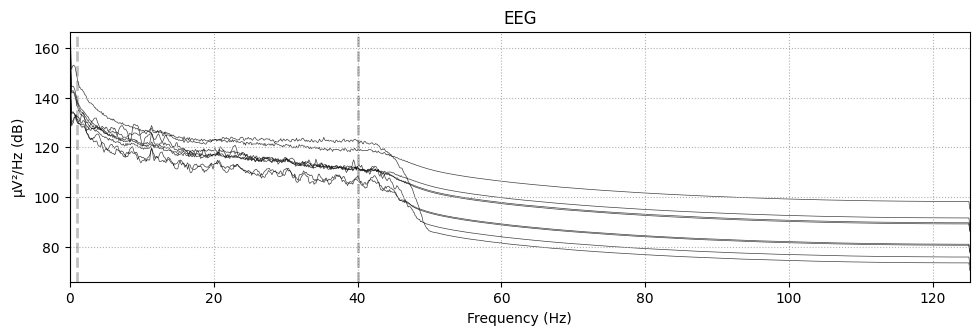

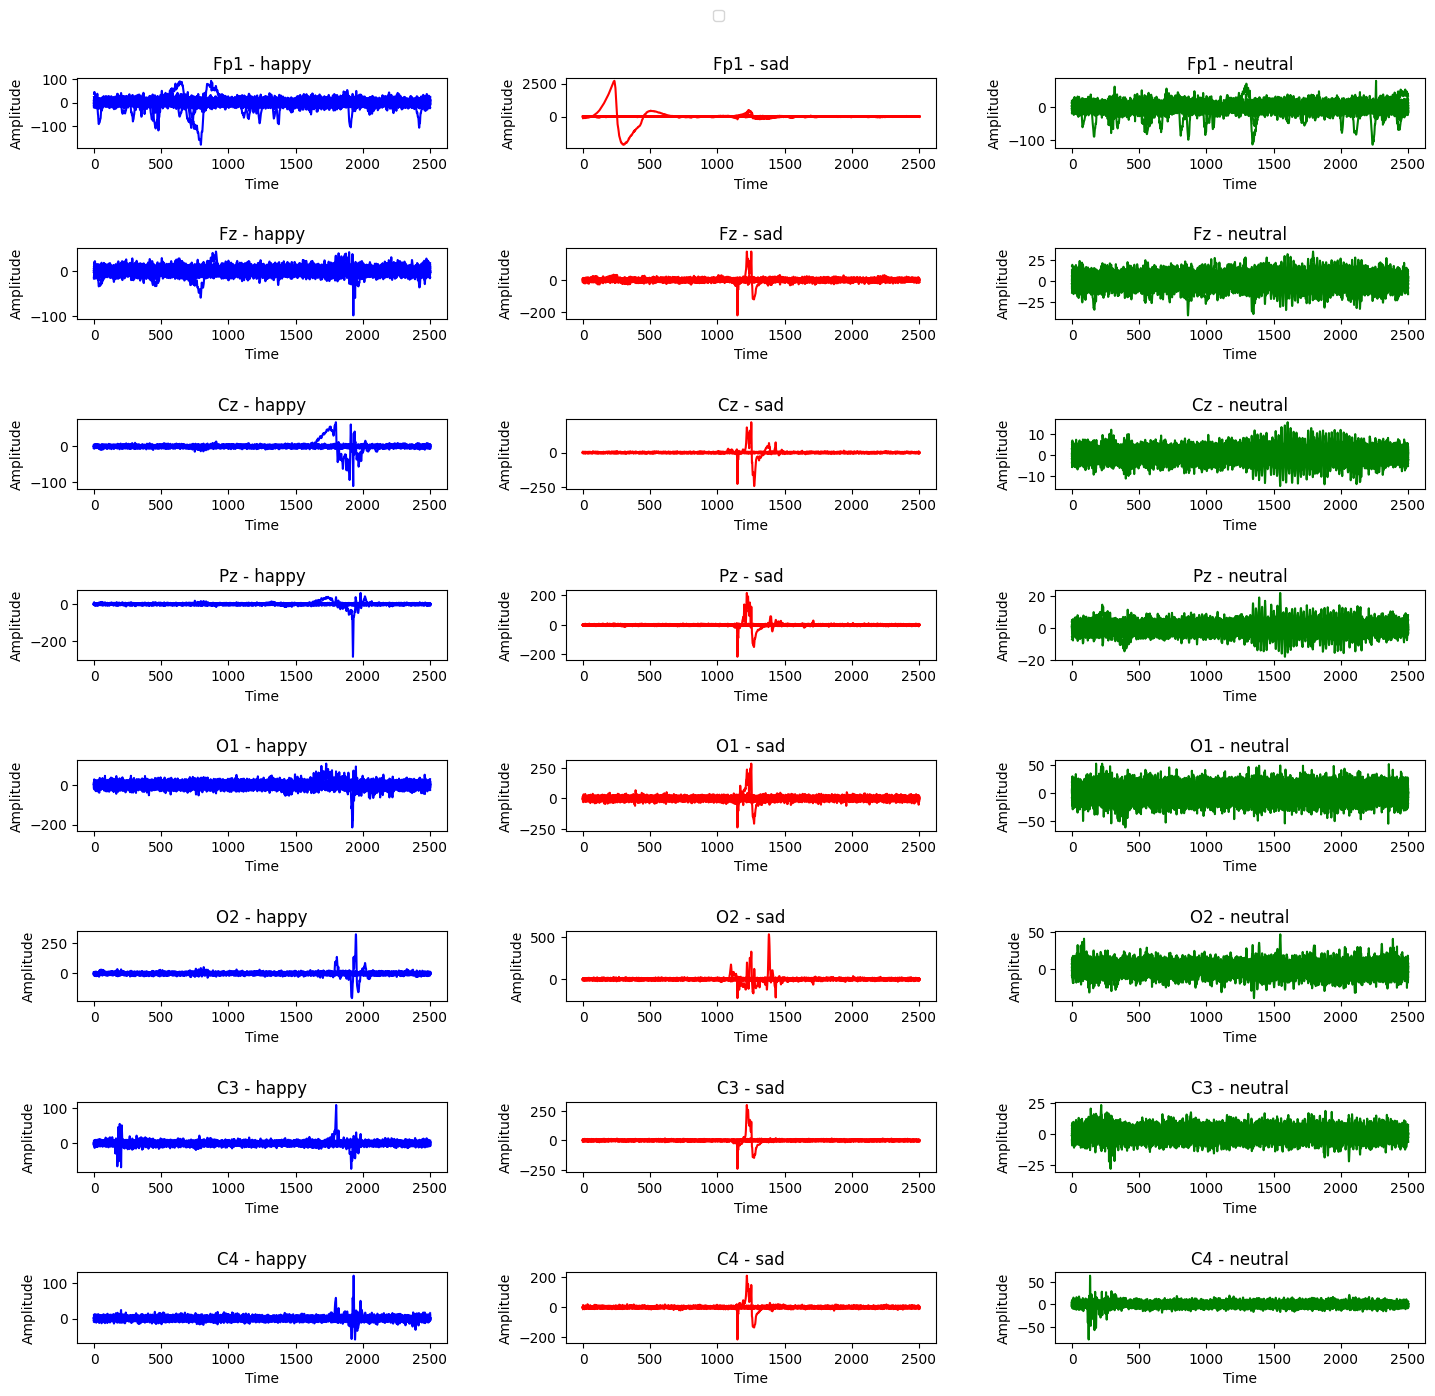

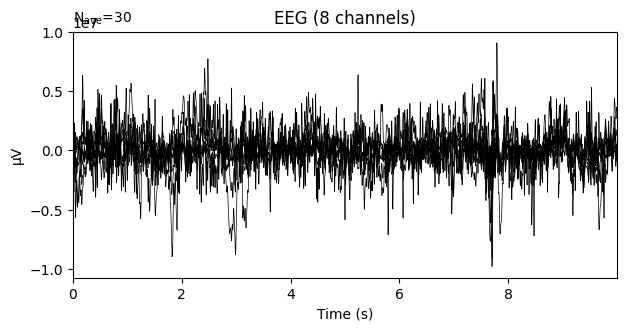

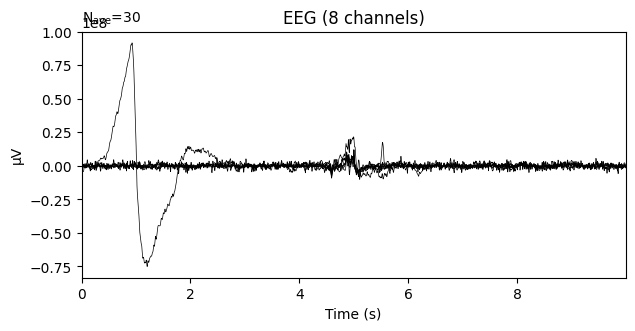

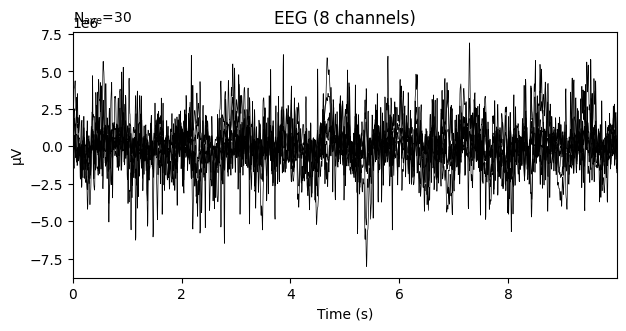

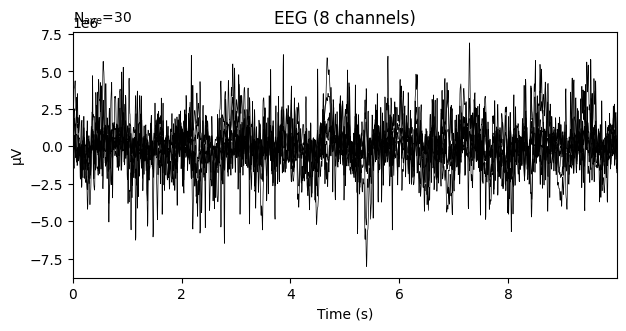

In [47]:
# plot the grand average ERP for all channels
erp = epochs_array['happy'].average()
erp2 = epochs_array['sad'].average()
erp3 = epochs_array['neutral'].average()

erp.plot()
erp2.plot()
erp3.plot()

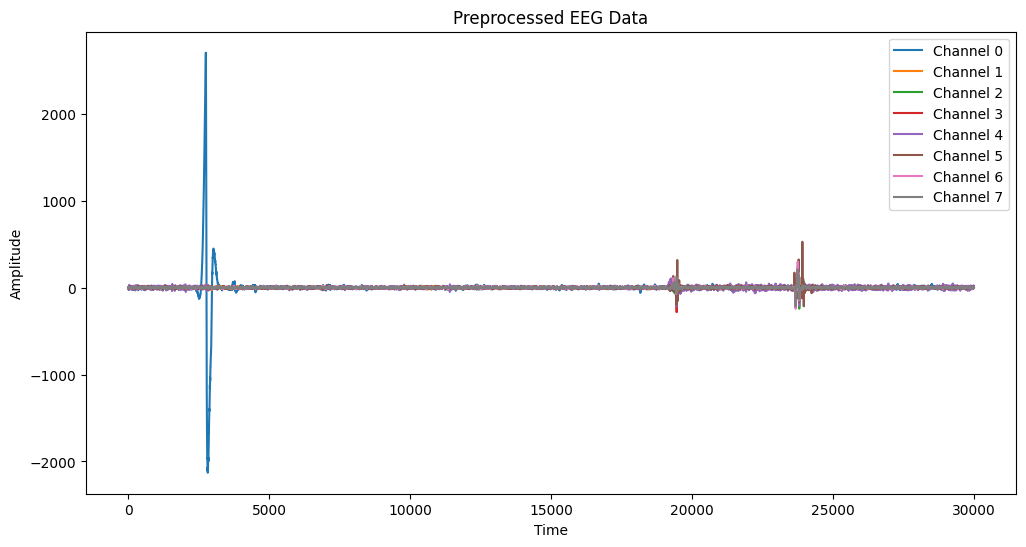

In [50]:
# Load preprocessed EEG data from a numpy file
data = df_cleaned

# Select a subset of channels and time points to visualize
channels = [0, 1, 2, 3, 4, 5, 6, 7]
time_points = range(20000, 50000)

# Plot the EEG data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data[channels][:, time_points].T)
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('Preprocessed EEG Data')
ax.legend(['Channel {}'.format(i) for i in channels])
plt.show()

In [52]:
def extract_amplitude(epochs):
    """Extracts amplitude features from EEG epochs across different frequencies.
    
    Parameters
    ----------
    epochs : mne.Epochs
        Epochs object containing the EEG data.
    
    Returns
    -------
    dict
        Dictionary containing the average amplitude values for delta (0-4 Hz), 
        theta (4-8 Hz), alpha (8-12 Hz), beta (12-30 Hz), and gamma (30-100 Hz) 
        frequencies for each channel.
    """
    # Define frequency bands of interest
    freq_bands = {'Delta': (0, 4),
                  'Theta': (4, 8),
                  'Alpha': (8, 12),
                  'Beta': (12, 30),
                  'Gamma': (30, 100)}
    
    # Initialize dictionary to store amplitude features
    amp_features = {}
    
    # Loop over frequency bands and channels to compute average amplitudes
    for band, (fmin, fmax) in freq_bands.items():
        for ch in epochs.ch_names:
            # Extract epochs and compute average amplitude for current band and channel
            band_epochs = epochs.copy().filter(fmin, fmax, picks=ch)
            avg_amp = np.mean(np.abs(band_epochs.get_data()), axis=(0, 2))
            # Add average amplitude to dictionary
            if ch not in amp_features:
                amp_features[ch] = {}
            amp_features[ch][band] = avg_amp
            amp_features
    
    return amp_features

In [53]:
extract_amplitude(epochs_array)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.650 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.650 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.650 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.650 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.650 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.650 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband att

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.650 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband att

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 277 samples (1.107 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 277 samples (1.107 sec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 277 samples (1.107 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 30 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 111 samples (0.444 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 30 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 30 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 111 samples (0.444 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 30 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

{'Fp1': {'Delta': array([9.3430502 , 5.33783253, 2.01741057, 2.23611857, 8.34691399,
         5.51253709, 3.17078255, 3.30138431]),
  'Theta': array([3.56064559, 5.33783253, 2.01741057, 2.23611857, 8.34691399,
         5.51253709, 3.17078255, 3.30138431]),
  'Alpha': array([2.58436321, 5.33783253, 2.01741057, 2.23611857, 8.34691399,
         5.51253709, 3.17078255, 3.30138431]),
  'Beta': array([3.58722789, 5.33783253, 2.01741057, 2.23611857, 8.34691399,
         5.51253709, 3.17078255, 3.30138431]),
  'Gamma': array([2.13083192, 5.33783253, 2.01741057, 2.23611857, 8.34691399,
         5.51253709, 3.17078255, 3.30138431])},
 'Fz': {'Delta': array([10.98905013,  3.96145846,  2.01741057,  2.23611857,  8.34691399,
          5.51253709,  3.17078255,  3.30138431]),
  'Theta': array([10.98905013,  2.34534685,  2.01741057,  2.23611857,  8.34691399,
          5.51253709,  3.17078255,  3.30138431]),
  'Alpha': array([10.98905013,  1.99508412,  2.01741057,  2.23611857,  8.34691399,
          5.5

In [54]:
def extract_time_frequency(epochs):
    """Extract time-frequency features from epochs data."""
    # Define frequency bands of interest
    freq_bands = {'theta': [4, 8],
                  'alpha': [8, 12],
                  'beta': [12, 30],
                  'gamma': [30, 80]}

    # Extract time-frequency data using Morlet wavelets
    power = mne.time_frequency.tfr_morlet(epochs, n_cycles=2, freqs=np.arange(2, 81, 2),
                                          use_fft=True, return_itc=False, decim=2, n_jobs=1)
    
    # Compute the average power in each frequency band
    tf_features = dict()
    for band, freq_limits in freq_bands.items():
        freq_mask = np.logical_and(power.freqs >= freq_limits[0], power.freqs < freq_limits[1])
        band_power = power.data[:, freq_mask, :].mean(axis=1)
        tf_features[band] = band_power

    return tf_features


In [55]:
extract_time_frequency(epochs_array)

{'theta': array([[2259.46443755, 2326.96433166, 2353.72047054, ..., 1058.54437673,
         1020.84971239,  970.24993522],
        [ 373.10514934,  403.98559572,  432.17488865, ...,  414.48555688,
          393.57617577,  369.20045229],
        [  40.38757789,   43.88475379,   46.9851943 , ...,   52.2144698 ,
           49.06795106,   45.58503793],
        ...,
        [ 389.31894465,  429.64297369,  469.36937678, ...,  473.37213742,
          437.07158749,  399.5314802 ],
        [ 113.22901945,  122.76431454,  131.45518263, ...,  123.10743948,
          115.31686151,  106.62727433],
        [ 119.74371059,  128.37494039,  135.48594975, ...,  114.68168199,
          109.56750838,  103.38570878]]),
 'alpha': array([[1231.58889393, 1194.75847733, 1079.51621634, ...,  533.56041919,
          535.86044736,  523.05565766],
        [ 234.71505062,  253.42391596,  263.18404575, ...,  255.46336379,
          246.72529524,  231.89954208],
        [  26.30606966,   29.79384443,   32.29075914, .

In [56]:
def extract_ersp(epochs, event_id):
    """Extracts event-related spectral perturbation (ERSP) from EEG epochs for a specific event type.
    
    Parameters
    ----------
    epochs : mne.Epochs
        Epochs object containing the EEG data.
    event_id : int
        The ID of the event type to calculate ERSP for.
    
    Returns
    -------
    dict
        Dictionary containing the ERSP values for each frequency and time point.
    """
    # Define frequency range and number of cycles for Morlet wavelet
    freqs = np.logspace(*np.log10([3, 35]), num=8)
    n_cycles = freqs / 2.

    # Calculate ERSP using Morlet wavelets
    power, itc = mne.time_frequency.tfr_morlet(epochs[event_id], freqs=freqs, n_cycles=n_cycles,
                                               return_itc=True, average=True, n_jobs=1)
    
    # Get time and frequency information
    times = epochs.times
    frequencies = power.freqs

    # Return ERSP values as dictionary
    return {'times': times, 'frequencies': frequencies, 'power': power.data}


In [57]:
extract_ersp(epochs_array, event_codes)

{'times': array([0.00000000e+00, 3.99629870e-03, 7.99259740e-03, ...,
        9.98675045e+00, 9.99074675e+00, 9.99474305e+00]),
 'frequencies': array([ 3.        ,  4.26130112,  6.05289576,  8.59773717, 12.21251569,
        17.34706894, 24.64036146, 35.        ]),
 'power': array([[[1244.04968706, 1261.26248224, 1277.86382239, ...,
          1012.56490077, 1024.56548948, 1032.38946865],
         [1106.52448334, 1150.41157779, 1193.27581724, ...,
           817.78523233,  806.45960869,  792.39068464],
         [ 610.64329339,  641.84114262,  672.64787708, ...,
           518.42090373,  499.41940753,  479.64074808],
         ...,
         [  71.06904114,   71.85731554,   72.25578583, ...,
            92.82381359,   89.98735438,   86.89077865],
         [  41.52054995,   44.92843709,   48.48552149, ...,
            38.44484471,   36.94400134,   35.45794096],
         [  21.40317309,   22.12736671,   22.81550176, ...,
            19.96675994,   18.87064194,   17.84852636]],
 
        [[ 89

In [58]:
def ttest_1samp_no_p(X, sigma=0.0, method='relative'):
    var = np.var(X, axis=0)
    if sigma > 0.0:
        limit = sigma * np.max(var) if method == 'relative' else sigma
        var += limit
    t_vals = np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
    df = X.shape[0] - 1
    return t_vals, df

# Get the data from the epochs
happy_epochs_data = happy_epochs.get_data()
sad_epochs_data = sad_epochs.get_data()
neutral_epochs_data = neutral_epochs.get_data()

# Calculate the number of epochs
n_epochs = happy_epochs_data.shape[0]

# Perform t-test for happy epochs
happy_t, happy_df = ttest_1samp_no_p(happy_epochs_data, n_epochs)

# Perform t-test for sad epochs
sad_t, sad_df = ttest_1samp_no_p(sad_epochs_data, n_epochs)

# Perform t-test for neutral epochs
neutral_t, neutral_df = ttest_1samp_no_p(neutral_epochs_data, n_epochs)

# Print the t-values for each condition
print(f"Happy t-value: {happy_t}")
print(f"Sad t-value: {sad_t}")
print(f"Neutral t-value: {neutral_t}")

# Calculate the average t-values for each condition
happy_avg_t = np.mean(happy_t)
sad_avg_t = np.mean(sad_t)
neutral_avg_t = np.mean(neutral_t)

# Print the average t-values for each condition
print(f"Happy average t-value: {happy_avg_t}")
print(f"Sad average t-value: {sad_avg_t}")
print(f"Neutral average t-value: {neutral_avg_t}")

Happy t-value: [[-0.01746432 -0.02523735 -0.0228716  ...  0.05768594  0.063403
   0.05767426]
 [-0.02029896 -0.01666358 -0.00716323 ...  0.02275811  0.02395923
   0.02577114]
 [-0.00592244 -0.00418577  0.00011499 ...  0.00244193  0.00286135
   0.00396254]
 ...
 [-0.01505797 -0.01453992 -0.0190516  ... -0.01014644 -0.00035841
   0.00558178]
 [-0.00642706 -0.00676307 -0.00644933 ... -0.00037288 -0.00157079
   0.00151558]
 [-0.00984372 -0.00508802  0.00451987 ...  0.02747242  0.02529461
   0.02183613]]
Sad t-value: [[-7.59729968e-03 -8.66355569e-03 -9.40726599e-03 ...  3.22959997e-03
   2.19304279e-03  5.41253626e-04]
 [-4.69738741e-04 -4.72240093e-04 -4.43224467e-04 ...  1.47318465e-03
  -6.04132039e-04 -2.82859830e-03]
 [ 8.84214981e-04  9.02646102e-04  8.04798039e-04 ...  3.62946672e-04
  -1.64271962e-04 -7.78463745e-04]
 ...
 [-2.87211217e-03 -3.44135965e-03 -3.84041105e-03 ... -2.16552507e-03
  -2.36051091e-03 -1.95311610e-03]
 [ 9.73596385e-04  1.20557339e-03  8.15982932e-04 ... -6.